#### AI powered Travel planning agent to plan a trip for a user including costing


In [1621]:
#%config Completer.use_jedi = True

In [1622]:
from langchain_community.tools import DuckDuckGoSearchRun , OpenWeatherMapQueryRun
from langchain_tavily import TavilySearch
from langchain.tools.google_serper import GoogleSerperResults
from dotenv import load_dotenv
import os
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages.human import HumanMessage
from langchain_core.output_parsers import StrOutputParser
import requests
from langchain_core.tools import InjectedToolArg
from typing import Annotated, Optional, List, Dict, TypedDict, Literal
from langchain.tools import StructuredTool
from pydantic import BaseModel, Field, constr
from loguru import logger
from langchain.globals import set_debug
from langchain import hub
#from langchain.agents import create_react_agent, AgentExecutor
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, MessagesState,END, START, add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph.state import CompiledStateGraph
from IPython.display import display, Image
from langchain_community.utilities import GoogleSerperAPIWrapper, GoogleSearchAPIWrapper
from langchain_community.utilities import SerpAPIWrapper
import json
from langchain_google_genai import ChatGoogleGenerativeAI


#http://python.langchain.com/docs/how_to/migrate_agent/

In [1623]:
load_dotenv("../../../tokens/token_env")

True

In [1624]:
os.environ['EXCHANGE_RATE_API_KEY'] = os.getenv("EXCHANGE_RATE_API_KEY")
os.environ['WEATHERSTACK_API_KEY'] = os.getenv("WEATHERSTACK_API_KEY")
os.environ['SERPAPI_API_KEY'] = os.getenv("SERPAPI_API_KEY")
os.environ['GEMINI_API_KEY'] = os.getenv("GEMINI_API_KEY")
os.environ['GOOGLE_API_KEY'] = os.getenv("GEMINI_API_KEY")

In [1625]:
websearch = DuckDuckGoSearchRun()

In [1626]:
@tool('GetCurrencyRate')
def get_currency_rate(base_currency:str , target_currency:str) -> dict:
    """
        Given a Base currency and target Currecy, this tool will return current coversion rate
    """
    print("get currecy rate")
    url = f'https://v6.exchangerate-api.com/v6/{os.getenv("EXCHANGE_RATE_API_KEY")}/pair/{base_currency.upper()}/{target_currency.upper()}'
    response = requests.get(url)
    data = response.json()
    return data

In [1627]:
@tool
def addtool (a: float , b:float) -> float:
    """
        To add given two mumbers
         Args:
            a (float): The first number.
            b (float): The second number.
        Returns:
    """
    print("add two numbers")
    return a+b

In [1628]:
@tool
def dividetool (a: float , b:float) -> float:
    """
        To divide given two mumbers
         Args:
            a (float): The first number.
            b (float): The second number.
        Returns:
    """
    print("divide two numbers")
    return a/b

In [1629]:
@tool
def multipytool (a: float , b:float) -> float:
    """
        To multiply given two mumbers
         Args:
            a (float): The first number.
            b (float): The second number.
        Returns:
    """
    print("multiply two numbers")
    return a*b

In [1630]:
@tool
def get_current_weather(city:str) -> dict:
    """
        Given a the city  this tool will return current weather in that city
    """
    print("get weather")
    url = f'http://api.weatherstack.com/current?access_key={os.getenv("WEATHERSTACK_API_KEY")}&query={city}'
    response = requests.get(url)
    data = response.json()
    return data

In [1631]:
@tool
def format_document(state: MessagesState):
    """
        Formats the messages in the given MessagesState for documentation or display purposes.

        Args:
            state (MessagesState): The state containing a list of messages.

        Returns:
            MessagesState: The same state after printing its messages.
    """
    print("inside format document")
    with open ("plan.txt", 'w') as f:
        for messsage in state['messages']:
            if messsage.content is not None:
                f.write(messsage.content)
            else:
                f.write("no plan generated")


In [1632]:
#get_current_weather.invoke("Austin")

In [1633]:

#get_currency_rate.invoke({'base_currency': 'USD', 'target_currency': 'GBP'})

In [1634]:
@tool
def convert_currency(base_currency_value: float, conversion_rate: float) -> float:    # we do not want tool to inject the coversion rate from LLM learning use InjectedToolArg Annotated[float, InjectedToolArg]
    """ 
    Converts a given amount in the base currency to the target currency using the provided conversion rate.

    Args:
        base_currency_value (float): The amount in the base currency to be converted.
        conversion_rate (float): The conversion rate from base currency to target currency.

    Returns:
        float: The equivalent amount in the target currency.
    """

    print("convert_func multiply")
    return base_currency_value  * conversion_rate

In [1635]:
@tool
def web_search(query: str) -> str:
    """
    A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.
    use this tool for General search if not specific tool avaiable 
    """
    search=DuckDuckGoSearchRun()
    return search.invoke(query)

In [1636]:
@tool
def search_local_attractions(city: str) -> dict:
    """

        Searches for attractions in the specified location using the Google Serp API.

        Args:
            location (str): The location (city, region, or address) to search for attractions

        Returns:
            dict or None: The JSON response from the API containing attractions information if successful, otherwise None.
    """
    print('search attractions')
    baseurl = "https://serpapi.com/search"
    params = {
        "engine": "google_local",
        "q": "attractions",
        "location": f"{city}",
        "api_key": os.getenv("SERPAPI_API_KEY"),
        "num": 10
    }
    search = requests.get(baseurl,params=params)
    results = search.json() 
    return results

#search_local_attractions.invoke({'city': "milan, italy"})

In [1637]:
@tool
def search_hotel_places(city: str , check_in_date: str , check_out_date: str, budget: Optional[float]=100) -> dict:
    """

        Searches for hotels in the specified location using the Google Serp API.

        Args:
            location (str): The location (city, region, or address) to search for hotels.

        Returns:
            dict or None: The JSON response from the API containing hotel information if successful, otherwise None.
    """
    print('search hotel')
    baseurl = "https://serpapi.com/search"
    params = {
        "engine": "google_hotels",
        "q": f"best hotel in {city} under {budget}",
        "check_in_date": check_in_date,
        "check_out_date": check_out_date,
        "api_key": os.getenv("SERPAPI_API_KEY"),
        "num": 10
    }
    search = requests.get(baseurl,params=params)
    response = search.json() 
    #result = response['properties']
    result={ property['name']: property['total_rate'] for property in response['properties'] if  property['type'] == 'hotel' }
    return result

#search_hotel_places.invoke({'city': "Austin", 'check_in_date': "2025-06-21", 'check_out_date': "2025-06-25"})

In [1638]:
@tool
def search_local_restaurant(city: str) ->dict:
    """

        Searches for local restaurant in the specified location using the Google Serp API.

        Args:
            location (str): The location (city, region, or address) to search for hotels.

        Returns:
            dict or None: The JSON response from the API containing restaurant information if successful, otherwise None.
    """
    print('search restaurant')
    baseurl = "https://serpapi.com/search"
    params = {
        "engine": "google_local",
        "q": "food,dining,restaurant,cuisine",
        "location": f"{city}",
        "api_key": os.getenv("SERPAPI_API_KEY"),
        "num": 10
    }
    search = requests.get(baseurl,params=params)
    response = search.json()
    return response

In [1639]:
result=search_local_restaurant.invoke({"city": "milan, italy"})
print(type(result))

search restaurant
<class 'dict'>


In [1640]:
tools = [get_currency_rate, convert_currency, web_search, get_current_weather,format_document,addtool,multipytool,dividetool,search_hotel_places,search_local_attractions,search_local_restaurant]

In [1641]:
#define a model
#model = ChatOpenAI(model='gpt-4o', temperature=0.2)
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash-001')

In [1706]:
SYSTEM_PROMPT = """

You are an AI Travel Planner and Expense Manager. Your task is to assist users in planning trips to any city worldwide using reasoning and tools.

You follow the **ReAct pattern**:
1. Think about what the user needs.
2. Decide which tool to use and why.
3. Call the tool using the correct arguments.
4. Observe the result.
5. Repeat reasoning and tool usage as needed.
6. Finally, return a complete, friendly, and well-organized travel plan.
7. Try Use the provided tools before trying for generic web_search tool

Be thoughtful and structured. Use tools only when required. Wait for tool results before deciding the next step.

If the user provides a destination and number of days, start by gathering key information like attractions, weather, and hotels. Calculate costs, convert currency, generate an itinerary, and end with a trip summary.
Correctly calcuate the trip days and use it for Estimating the cost Always get current coversion rate of the currency  and covert appropriatly . check the local weather during the time.Add a plan to visit nearby attractions.
Do not make any assumption
Your final response must be complete and organized, using markdown formatting (headers, bullet points) for easy reading. You should never hallucinate data — always use tools to get real-time or accurate info.

Let's get started.


"""
def call_llm(state: MessagesState):
    # SYSTEM_PROMPT = SystemMessage(content="you are a helpful travel assistance helping individuals to plan their trip.")
    #print(state['messages']
    tools = [get_currency_rate, convert_currency, web_search,get_current_weather,format_document,addtool,multipytool,dividetool,search_hotel_places,search_local_attractions,search_local_restaurant]
    model_with_tools = model.bind_tools(tools)
    resp = model_with_tools.invoke([SYSTEM_PROMPT] + state['messages'])
    return {'messages': [resp]}

In [1707]:
def create_workflow()-> CompiledStateGraph:
    builder = StateGraph(MessagesState)
    tools = [get_currency_rate, convert_currency, web_search,get_current_weather,format_document,addtool,multipytool,dividetool,search_hotel_places,search_local_attractions,search_local_restaurant]
    builder.add_node("Travel_Agent", call_llm)
    builder.add_node("tools", ToolNode(tools))
    
    builder.add_edge(START, "Travel_Agent")
    builder.add_conditional_edges(
    "Travel_Agent",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,    
    )
    builder.add_edge("tools", "Travel_Agent")
    app = builder.compile()
    return app

In [1708]:
workflow = create_workflow()

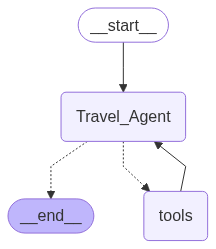

In [1709]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [1710]:
# messages = [HumanMessage(content="""I want to visit Milan, Italy from 2025-06-20 to 2025-06-22.
#                          - Correctly calcuate the trip days and use it for Estimating the cost 
#                          - Estimate a cost in INR for whole stay including hotel and food for daily 1 lunch and 1 breakfast
#                          - allways get current coversion rate of the currency  and covert appropriatly  
#                          - select one hotel under euros 500 which near to the city center, 
#                          - check weather during the time 
#                          - plan a trip for me to visit nearby attractions.
#                          - please select 5 different local dinining with price range. 
#                          - Do not make any assumption
#                         """)]
messages = [HumanMessage(content="""I want to visit Milan, Italy from 2025-06-20 to 2025-06-22.
                         - Esitmate the cost of the trip in INR as my transcation currency 
                         - select one hotel under euros 500 which near to the city center, 
                         - please select 5 different local dinining with price range.
                         - I would like to visit 2-3 attractions per day during the stay
                        """)]

In [1711]:
set_debug(False)

In [1712]:
resp=workflow.invoke({'messages': messages})


search attractions
search hotel
get weather
search restaurant
get currecy rate


In [1713]:
for m in resp['messages']:
     m.pretty_print()


================================ Human Message =================================

I want to visit Milan, Italy from 2025-06-20 to 2025-06-22.
                         - Esitmate the cost of the trip in INR as my transcation currency 
                         - select one hotel under euros 500 which near to the city center, 
                         - please select 5 different local dinining with price range.
                         - I would like to visit 2-3 attractions per day during the stay
                        
================================== Ai Message ==================================

Okay, I can help you plan your trip to Milan! Here's how I'll approach this:

1.  **Gather Information:** I'll start by using the tools to find local attractions, weather information for Milan in June, and hotels that fit your budget and location preferences.
2.  **Estimate Costs:** I'll find a hotel within your budget, get current currency conversion rates (EUR to INR), and estimate dinin

In [1714]:
from IPython.display import Markdown

In [1715]:
Markdown(resp['messages'][-1].content)

Here is a detailed travel plan for your trip to Milan, Italy, from June 20, 2025, to June 22, 2025.

### Trip Overview

*   **Destination:** Milan, Italy
*   **Duration:** 3 days (2 nights)
*   **Dates:** June 20, 2025 - June 22, 2025

### 1. Accommodation

Based on your preference for a hotel near the city center with a budget under EUR 500, here's a suitable option:

*   **Hotel:** Crowne Plaza Milan City, an IHG Hotel
*   **Cost:** EUR 479 (approximately INR 47,649) for 2 nights

### 2. Weather

The weather in Milan during this period is expected to be sunny with a temperature of 26°C.

### 3. Daily Itinerary

#### Day 1: June 20, 2025

*   **Morning:**
    *   **Attraction:** Piazza del Duomo. It's one of the main landmarks in Milan.
*   **Afternoon:**
    *   **Attraction:** Highline Milano.
*   **Evening:**
    *   **Restaurant:** Bertarelli (Italian).

#### Day 2: June 21, 2025

*   **Morning:**
    *   **Attraction:** Piazza Gae Aulenti.
*   **Afternoon:**
    *   **Attraction:** Piazza Mercanti.
*   **Evening:**
    *   **Restaurant:** Gigi Gastronomia (€10-€20).

#### Day 3: June 22, 2025

*   **Morning:**
    *   **Attraction:** Porta Ticinese Medievale.
*   **Afternoon:**
    *   **Attraction:** Ancient Lavoir (Vicolo Lavandai).
*   **Evening:**
    *   **Restaurant:** Hot rock Restaurant &Bar (€20–€30).

### 4. Dining Options

Here are five local dining options with price ranges:

1.  **Sofia Kitchen and Bar** (Restaurant)
2.  **Gigi Gastronomia:** (€10–€20)
3.  **Fainà ristorante ligure:** (€10–€20)
4.  **Bloomy 2 - 金源阁:** (€10–€20)
5.  **Hot rock Restaurant &Bar:** (€20–€30)

### 5. Estimated Trip Costs (in INR)

*   **Hotel:** INR 47,649
*   **Attractions:** Assuming an average entry fee of INR 1,500 per attraction x 6 = INR 9,000
*   **Food:** Assuming an average of INR 4,000 per day = INR 12,000
*   **Miscellaneous:** INR 5,000

**Total Estimated Cost:** INR 73,649

**Note:**
Currency conversion rate used: 1 EUR = INR 99.4611.